In [61]:
# Importing important things for our code to work correctly!
import hoomd
import hoomd.md
import json
import numpy as np
import ex_render
import matplotlib.pyplot as plt
import freud

In [45]:
# Important variables so we don't have to scroll through all the code 
particles = 1
epsilon_sticky = 50
sigma_sticky = 1.1
dt = 0.005
kT = 0.1
xaxis = 10
yaxis = 10
runTime = int(1e5)
gsd_period = int(2e3)

def autocorr1D(array):
    '''Takes in a linear numpy array, performs autocorrelation
       function and returns normalized array with half the length 
       of the input'''
    ft = np.fft.rfft(array-np.average(array)) 
    acorr = np.fft.irfft(ft*np.conjugate(ft))/(len(array)*np.var(array))
    return acorr[0:len(acorr)//2]

def get_decorr(acorr):
    return np.argmin(acorr>0)

def error_analysis(data):
    """Returns the standard and relative error given a dataset in a 1D numpy array"""
    serr = np.std(data)/np.sqrt(len(data))
    rel_err = np.abs(100* serr/np.average(data))
    return (serr, rel_err)

In [9]:
# Initializing where our code will run
hoomd.context.initialize("");

# Creating a unitcell with three particles as our center. 
# These are our rigid center particles. 
# The a1, a2, and a3 define our box size.
# The mass and moment of inertia were found by running init_wrapper on the trapezoid made 
# in mbuild in a different file. 
uc = hoomd.lattice.unitcell(N = particles,
                           a1 = [18, 0, 0],
                           a2 = [0, 18, 0],
                           a3 = [0, 0, 0],
                           dimensions = 2,
                           position = [[0,0,0]],
                           type_name = ['_R0'],
                           mass = [45.0],
                           moment_inertia = [[65.83333333, 322.5, 388.33333333]],
                           orientation = [[1,0,0,0]])

# This replicates the rigid center particle 6 in the x direction and 2 in the y direction
system = hoomd.init.create_lattice(unitcell=uc, n = [xaxis,yaxis])

# Adding the types of particles that we want. 
# Z is normal particles
# A,B,C,D,E,F are our sticky particles
system.particles.types.add('Z')
system.particles.types.add('A')
system.particles.types.add('B')


# This fills in the positions of our particles to make our trapezoid
# All positions were found using init_wrapper in another file

with open("../jupyterfiles/rigid_info_jigsaw.json") as json_data:
         rigid_body_data = json.load(json_data)
particle_positions = rigid_body_data[0]["r_positions"] 

particle_positions = np.array(particle_positions)
# This divides the positions by 10 so they aren't so spread out and look nicer in the simulations
particle_positions /= 10

# Creates the rigid body but nothing is in it yet
rigid = hoomd.md.constrain.rigid()

# Puts the particles in their correct positions based on their types
bottom_right = 'Z'
right_b_mid = 'Z'
bottom4Rmid = 'Z'
bottom3Rmid = 'Z'
right_middle = 'Z'
right_u_mid = 'Z'
top_right = 'Z'
bottom2Rmid = 'Z'
top2Rmid = 'Z'
bottom1Rmid = 'Z'
top1Rmid = 'A'
bottom_middle = 'Z'
top_middle = 'A'
bottom1Lmid = 'Z'
top1Lmid = 'Z'
bottom2Lmid = 'Z'
top2Lmid = 'Z'
top_left = 'Z'
bottom4Lmid = 'Z'
left_u_mid = 'Z'
bottom_left = 'Z'
left_b_mid = 'B'
bottom3Lmid = 'Z'
left_middle = 'B'
rigid.set_param('_R0',
               types=[bottom_right, bottom4Rmid, right_b_mid, bottom3Rmid, 'Z', 
                      right_middle, right_u_mid, top_right, bottom2Rmid, 'Z', 'Z', 'Z', 
                      top2Rmid, bottom1Rmid, 'Z', 'Z', 'Z', top1Rmid, bottom_middle, 'Z', 
                      'Z', 'Z', top_middle, bottom1Lmid, 'Z', 'Z', 'Z', top1Lmid, 
                      bottom2Lmid, 'Z', 'Z', 'Z', top2Lmid, bottom3Lmid, 'Z', 'Z', 'Z', 
                      top_left, bottom4Lmid, 'Z', 'Z', left_u_mid, bottom_left, left_b_mid, 
                      left_middle],
               # Sets positions of constituent particles
               positions=particle_positions)

rigid.create_bodies()

# Identifying our neighborlist
nl = hoomd.md.nlist.cell()

# Lennard Jones potential is specified with the desired r_cut value
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)

# Helps not cut the potential off so abruptly
lj.set_params(mode='xplor')

# Sets the interactions between the different groups of particles.

# Interations dealing with just rigid centers
lj.pair_coeff.set('_R0', '_R0', epsilon=0, sigma=0, r_cut=False)


# Interactions dealing with particle A
lj.pair_coeff.set('A','A', epsilon=0, sigma=0, alpha=0)
lj.pair_coeff.set('A', '_R0', epsilon=0, sigma=0)
lj.pair_coeff.set('A', 'B', epsilon=0, sigma=0, alpha=0)
lj.pair_coeff.set('A', 'Z', epsilon=2, sigma=0.9, alpha=0) # First trap was 1, 0.5

# Interactions dealing with particle B
lj.pair_coeff.set('B','B', epsilon=0, sigma=0, alpha=0)
lj.pair_coeff.set('B', '_R0', epsilon=0, sigma=0)
lj.pair_coeff.set('B', 'Z', epsilon=2, sigma=0.9, alpha=0)

# Interactions dealing with particle Z
lj.pair_coeff.set('Z','Z', epsilon=2, sigma=0.9, alpha=0)
lj.pair_coeff.set('Z', '_R0', epsilon=0, sigma=0)

hoomd.md.integrate.mode_standard(dt=dt);

# Creates the rigid_center group and applies langevin forces to them
rigid_center = hoomd.group.rigid_center()
integrate = hoomd.md.integrate.langevin(group=rigid_center, kT=kT, seed=42);

# Writes our results into a .log file
hoomd.analyze.log(filename="runs/jigsaw_asymmetric.log",
                 quantities=['potential_energy',
                            'translational_kinetic_energy',
                            'rotational_kinetic_energy'],
                 period=100,
                 overwrite=True);

# Writes the simulation into a .gsd file
hoomd.dump.gsd("runs/jigsaw-traj.gsd",
              period=gsd_period,
              group=hoomd.group.all(),
              overwrite=True);

# Let's run it!
hoomd.run(runTime)


notice(2): Group "all" created containing 100 particles
notice(2): constrain.rigid(): Creating 100 rigid bodies (adding 4500 particles)
notice(2): Group "rigid_center" created containing 100 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4600
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 16976 / 100000 | TPS 1697.57 | ETA 00:00:48
Time 00:00:20 | Step 34019 / 100000 | TPS 1704.29 | ETA 00:00:38
Time 00:00:30 | Step 50914 / 100000 | TPS 1689.48 | ETA 00:00:29
Time 00:00:40 | Step 68062 / 100000 | TPS 1714.78 | ETA 00:00:18
Time 00:00:50 | Step 85079 / 100000 | TPS 1701.62 | ETA 00:00:08
Time 00:01:00 | Step 99227 / 100000 | TPS 1414.73 | ETA 00:00:00
Time 00:01:00 | Step 100000 / 100000 | TPS 1681.22 | ETA 00:00:00
Average TPS: 1653.92
---------
-- N

Initial


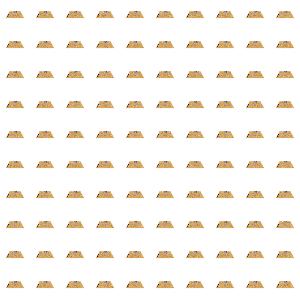

In [17]:
print("Initial")
snapshot = hoomd.data.gsd_snapshot('runs/jigsaw-traj.gsd',frame=0)
ex_render.render_disk_frame(snapshot)

Final


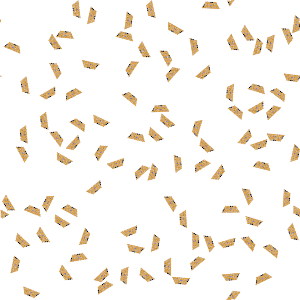

In [18]:
print("Final")
snapshot = hoomd.data.gsd_snapshot('runs/jigsaw-traj.gsd',frame=-1)
ex_render.render_disk_frame(snapshot)

In [21]:
# Can take a bit of time to read in the trajectory and render it. Be patient!
ex_render.display_movie(ex_render.render_disk_frame, 'runs/jigsaw-traj.gsd');
# Save as gif
#ex_render.display_movie(ex_render.render_disk_frame, 'runs/jigsaw-traj.gsd', f2="traj.gif");

In [90]:
def get_rdf(traj_file):
    snap = hoomd.data.gsd_snapshot(traj_file,frame=0)
    rdf = freud.density.RDF(rmax=snap.box.Lx/2, dr=0.01); # min(snap.box.Lx/2,4)
    for frame in range(runTime//gsd_period-1):
        snap = hoomd.data.gsd_snapshot(traj_file,frame=frame)
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly);
        rdf.accumulate(box, pos, pos);
    return rdf

In [92]:
rdf =get_rdf('runs/jigsaw-traj.gsd')

/Users/jennyfothergill/miniconda3/envs/hoomd/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


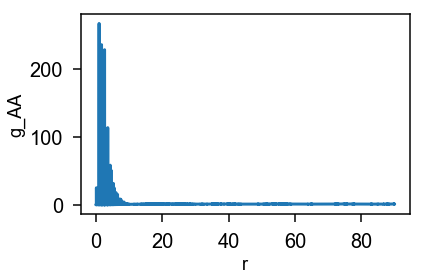

In [95]:
plt.plot(rdf.R, rdf.RDF) # use that accumulated RDF!
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA', fontsize=18)
plt.show()

In [114]:
traj_file = 'runs/jigsaw-traj.gsd'
snap = hoomd.data.gsd_snapshot(traj_file,frame=0)
pos = snap.particles.position;
center_ind = snap.particles.types.index('_R0')
center_pos=snap.particles.position[np.where(snap.particles.typeid == center_ind)]
print(center_pos)

[[-81. -81.   0.]
 [-81. -63.   0.]
 [-81. -45.   0.]
 [-81. -27.   0.]
 [-81.  -9.   0.]
 [-81.   9.   0.]
 [-81.  27.   0.]
 [-81.  45.   0.]
 [-81.  63.   0.]
 [-81.  81.   0.]
 [-63. -81.   0.]
 [-63. -63.   0.]
 [-63. -45.   0.]
 [-63. -27.   0.]
 [-63.  -9.   0.]
 [-63.   9.   0.]
 [-63.  27.   0.]
 [-63.  45.   0.]
 [-63.  63.   0.]
 [-63.  81.   0.]
 [-45. -81.   0.]
 [-45. -63.   0.]
 [-45. -45.   0.]
 [-45. -27.   0.]
 [-45.  -9.   0.]
 [-45.   9.   0.]
 [-45.  27.   0.]
 [-45.  45.   0.]
 [-45.  63.   0.]
 [-45.  81.   0.]
 [-27. -81.   0.]
 [-27. -63.   0.]
 [-27. -45.   0.]
 [-27. -27.   0.]
 [-27.  -9.   0.]
 [-27.   9.   0.]
 [-27.  27.   0.]
 [-27.  45.   0.]
 [-27.  63.   0.]
 [-27.  81.   0.]
 [ -9. -81.   0.]
 [ -9. -63.   0.]
 [ -9. -45.   0.]
 [ -9. -27.   0.]
 [ -9.  -9.   0.]
 [ -9.   9.   0.]
 [ -9.  27.   0.]
 [ -9.  45.   0.]
 [ -9.  63.   0.]
 [ -9.  81.   0.]
 [  9. -81.   0.]
 [  9. -63.   0.]
 [  9. -45.   0.]
 [  9. -27.   0.]
 [  9.  -9.   0.]
 [  9.   9

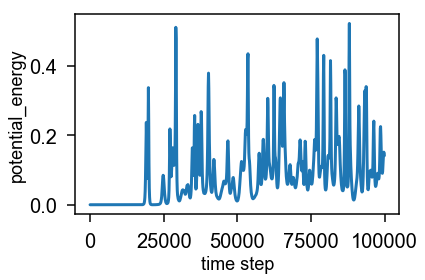

In [60]:
data = np.genfromtxt(fname='runs/jigsaw_asymmetric.log', skip_header=True);
plt.plot(data[:,0], data[:,1]); # 0 step, 1 pot_e, 2 trans_kin_e, 3 rot_kin_e
plt.xlabel('time step', fontsize=18);
plt.ylabel('potential_energy', fontsize=18);
plt.show()